In [3]:
#| default_exp segment_saliency

In [1]:
#| hide
!nvidia-smi

Wed Jul 26 15:36:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   25C    P8     7W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

In [127]:
#| hide
%pip install shapely

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [65]:
#| hide
%pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 22.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.8 MB/s eta 0:00:00:00:0100:01


In [1]:
#| hide
import os
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"

ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

NameError: name 'torch' is not defined

In [2]:
#| export
import torch
import numpy as np
import cv2
from ultralytics import YOLO

In [3]:
#| hide
torch.__version__

'1.13.1+cu117'

In [4]:
#| hide
%pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jeaxzz0b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jeaxzz0b
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=c5a9e63afb019c8c86f385ea6970047a902b11fdd9c2e8cb38bdc6bd6bd3cf0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-264ofp8v/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


In [5]:
#| hide
%pip install opencv-python pycocotools matplotlib onnxruntime onnx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 20.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 63.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 45.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp38-cp38-linux_x86_64.whl size=423874 sha256=2ddd54bd2160a305970d4934cf986acc8eb5c9a33f5d2863464fc23fc9f89ab4
  Stored in directory: /home/hashimi/.cache/pip/wheels/3e/08/ac/58126fe59992032701437336493f6132e1b723

In [8]:
#| hide
os.getcwd()

'/home/hashimi'

In [9]:
#| hide
os.chdir("/project/validating_attribution_techniques/")

In [10]:
#| hide
os.getcwd()

'/project/validating_attribution_techniques'

In [3]:
#| export
import matplotlib.pyplot as plt
from PIL import Image

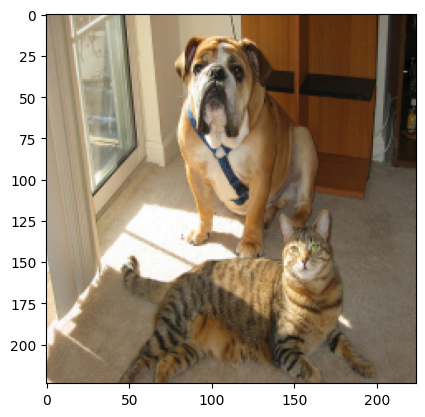

In [6]:
#| hide
current_dir = os.getcwd()
img_rel_path = "../examples/input.png"
# img_full_path = os.path.join(current_dir, img_rel_path)


image = Image.open(img_rel_path)
plt.imshow(image)

In [4]:
#| export
from segment_anything import SamPredictor, sam_model_registry

In [147]:
#| hide
# Source for the following functions: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [16]:
#| hide
sam_model_full_path = os.path.join(current_dir, "abid/vendors/sam_vit_b_01ec64.pth")
sam = sam_model_registry["vit_b"](checkpoint=sam_model_full_path)
predictor = SamPredictor(sam)

In [17]:
#| hide
predictor.set_image(np.array(image))

In [50]:
#| hide
input_point = np.array([[100, 50]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)

In [51]:
#| hide
masks.shape[-2:]

(224, 224)

In [103]:
#| hide
masks.shape

(3, 224, 224)

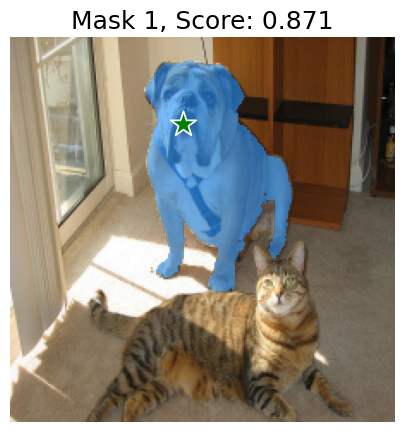

In [52]:
#| hide
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
    break

In [53]:
#| hide
mask = masks[0]

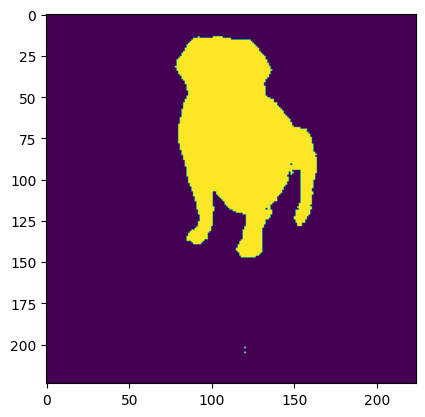

In [54]:
#| hide
mask.shape
plt.imshow(mask)

In [55]:
#| hide
coords = np.argwhere(mask == True)

In [56]:
#| hide
min_y, min_x = np.min(coords, axis=0)
max_y, max_x = np.max(coords, axis=0)

In [57]:
#| hide
bounding_box = [(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)]

In [58]:
#| hide
bounding_box

[(78, 14), (78, 205), (163, 205), (163, 14)]

In [59]:
#| hide
np.max(coords, axis=0)

array([205, 163])

In [60]:
#| hide
np.max(np.array([[12, 14], [2, 43]]), axis=0)

array([12, 43])

In [61]:
#| hide
np.max(np.array([2, 3, 4]))

4

In [62]:
#| hide
def border_coords(mask : np.array) -> np.array:
    border = np.zeros_like(mask, dtype=np.uint8)
    border[1:] = np.logical_xor(mask[:-1], mask[1:])
    border_coord = np.argwhere(border == 1)
    
    return border_coord, border

In [63]:
#| hide
border_coord, mask_edges = border_coords(mask)

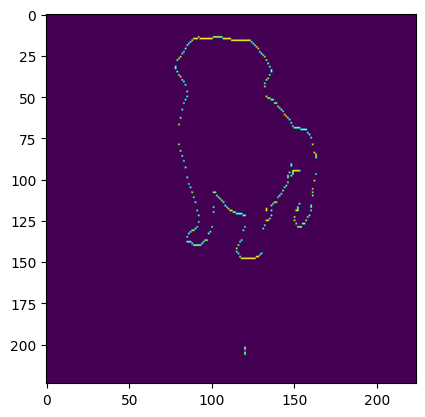

In [64]:
#| hide
plt.imshow(mask_edges)

In [7]:
#| export
from shapely.geometry import Point, Polygon

In [66]:
#| hide
point_objects = [Point(x, y) for y, x in border_coord]

In [67]:
#| hide
polygon = Polygon([[p.x, p.y] for p in point_objects])

In [9]:
type(Polygon([[0, 0], [1, 1], [2, 2]]))

shapely.geometry.polygon.Polygon

In [68]:
#| export
from skimage import measure

In [69]:
#| hide
mask.shape

(224, 224)

In [70]:
#| hide
contours = measure.find_contours(mask, 0.5, fully_connected='high')

In [71]:
#| hide
longest_coutour = max(contours, key=len)

In [72]:
#| hide
polygon = Polygon(longest_coutour)

In [3]:
#| export
def plot_polygon(axes, polygon: Polygon, x_axis: int, y_axis: int):
    """
    Plots shapely polygon using matplotlib
    
    input :
      - axes : matplotlib axis (Axis to draw on)
      - polygon : shapely polygon (Object to draw)
      - x_axis : int (value to scale the x-axis by)
      - y_axis : int (value to scale the y-axis by)
    """
    y, x = polygon.exterior.xy
    
#     fig, ax = plt.subplots(figsize=(5, 5))
    axes.plot(x, y, color='red', alpha=0.5)
    axes.fill(x, y)
    axes.set_xlim(0, x_axis)
    axes.set_ylim(y_axis, 0)

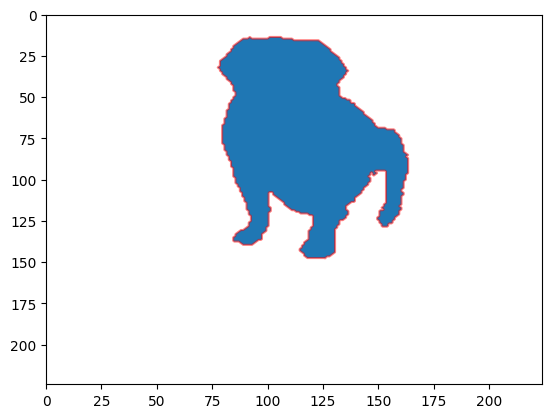

In [74]:
#| hide
plot_polygon(polygon, 224, 224)

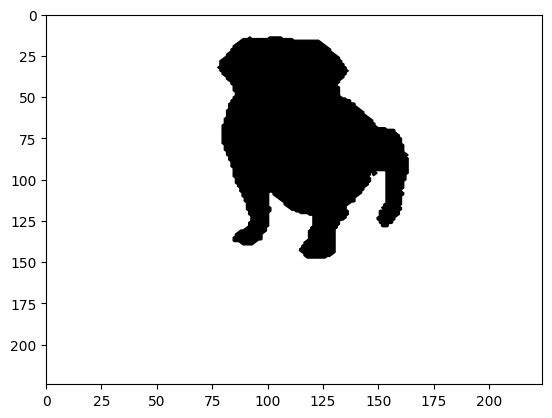

In [75]:
#| hide
y, x = polygon.exterior.xy
    
fig, ax = plt.subplots()
# ax.plot(x, y, color='red', alpha=0.5)
ax.fill(x, y, color='black')
plt.xlim(0, 224)
plt.ylim(224, 0)

fig.canvas.draw()

# plt.show()

In [76]:
#| hide
temp = longest_coutour[:, 0].copy()
longest_coutour[:, 0] = longest_coutour[:, 1]
longest_coutour[:, 1] = temp

In [77]:
#| hide
np_poly_coord = np.array(polygon.exterior.coords)

In [78]:
#| hide
np_poly_coord = np.round(np_poly_coord)

In [79]:
#| hide
np_mask = np.zeros_like(mask)

In [80]:
#| hide
np_mask.shape

(224, 224)

In [81]:
#| hide
def filled_array_from_polygon(arr, polygon):
    height, width = arr.shape
    for y in range(height):
        for x in range(width):
            if polygon.contains(Point(y, x)):
                arr[y, x] = 1

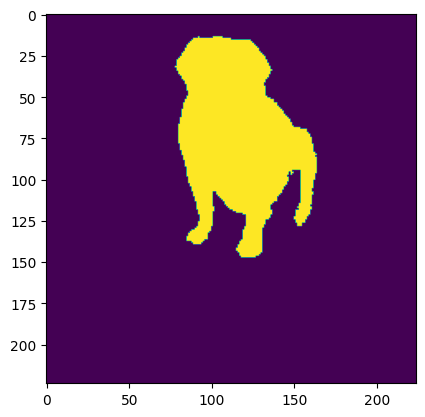

In [82]:
#| hide
filled_array_from_polygon(np_mask, polygon)
plt.imshow(np_mask)

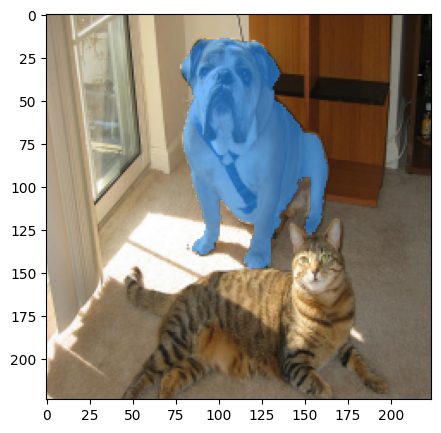

In [83]:
#| hide
#polygon.contains(Point(49, 120))
plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(np_mask, plt.gca())
# show_points(input_point, input_label, plt.gca())
# plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
# plt.axis('off')
plt.show()

In [148]:
#| export
from shapely.affinity import scale

In [ ]:
#| hide
scalad_poly = scale(polygon, xfact=0.5, yfact=0.5)

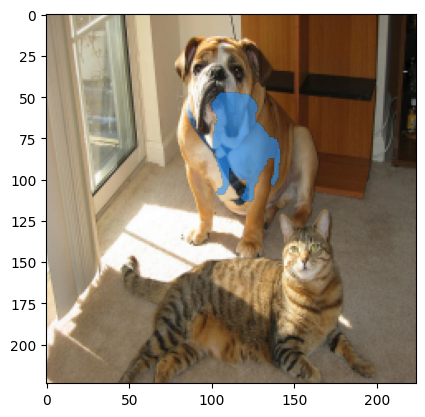

In [85]:
#| hide
np_mask = np.zeros_like(mask)
filled_array_from_polygon(np_mask, scalad_poly)
plt.imshow(image)
show_mask(np_mask, plt.gca())
plt.show()

In [86]:
#| hide
num_of_scaling_op = 7
saliency_value = 1/num_of_scaling_op

scale_val = 1;
np_mask = np.zeros_like(mask, dtype=float)

height, width = np_mask.shape
for _ in range(num_of_scaling_op):
    scaled_polygon = scale(polygon, xfact=scale_val, yfact=scale_val)
    for y in range(height):
        for x in range(width):
            if scaled_polygon.contains(Point(y, x)):
                np_mask[y, x] += saliency_value
    scale_val *= 0.8

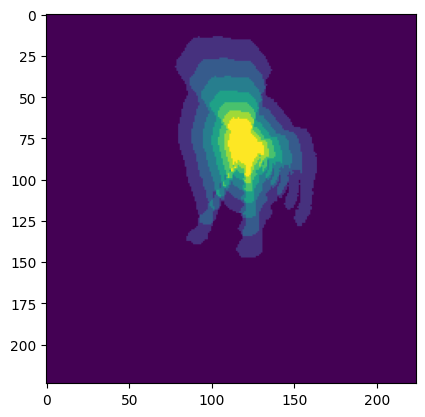

In [87]:
#| hide
plt.imshow(np_mask)

In [88]:
def visualize_saliency_overlay(np_img, mask): # , probs, cat_idx, classes):
    """
    Visualize the saliency maps on top of an image.
    
    input :
      - np_img : ndarray (Image to be visualized)
      - mask : ndarray (saliency map to be overlaid)
    """
#     patch_size = 16
#     steps = int(224/patch_size)
#     for x in range(steps-1):
#     pos = (x+1)*patch_size
#     np_img[:, pos:pos+1, :] = 0
#     np_img[pos:pos+1, :, :] = 0

    # np_img = np.array(img)
    fig, ax = plt.subplots()
    heatmap = Image.fromarray(mask)
    heatmap = np.array(heatmap.resize((np_img.shape[0], np_img.shape[1])))
    ax.imshow(np_img)
    heatmap = (heatmap / np.max(heatmap)) * 255.0
    ax.imshow(heatmap, cmap='turbo', # seismic, hot, Reds
              alpha=0.5)
    # ax.set_title(f"Class: {classes[cat_idx]} ({probs[0, cat_idx].item()*100:.2f}%)")
    plt.show()
    
    return heatmap

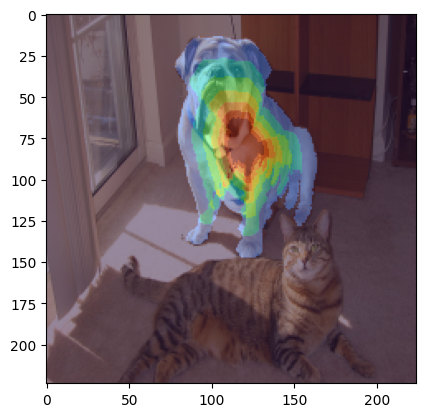

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [89]:
#| hide
# color = np.array([30/255, 144/255, 255/255, 1])
# mask_image = np_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
visualize_saliency_overlay(np.array(image), np_mask)
# plt.imshow(mask_image)
# plt.show()

In [90]:
#| export
from scipy.signal import convolve2d

In [91]:
#| hide
np_mask.shape

(224, 224)

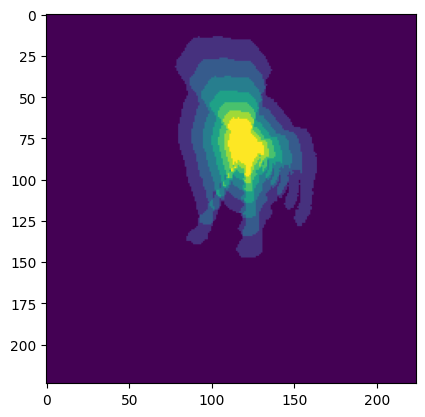

In [92]:
#| hide
plt.imshow(np_mask)

In [134]:
#| hide
kernel = np.array([
    [ 45,  78, 128,  78, 45],
    [ 78, 128, 170, 128, 78],
    [128, 170, 255, 170, 128],
    [ 78, 128, 170, 128, 78],
    [ 45,  78, 128,  78, 45],
])

In [135]:
kernel = kernel/kernel.sum()
kernel.sum()

1.0

In [136]:
#| hide
kernel

array([[0.01628664, 0.02823018, 0.04632646, 0.02823018, 0.01628664],
       [0.02823018, 0.04632646, 0.06152733, 0.04632646, 0.02823018],
       [0.04632646, 0.06152733, 0.09229099, 0.06152733, 0.04632646],
       [0.02823018, 0.04632646, 0.06152733, 0.04632646, 0.02823018],
       [0.01628664, 0.02823018, 0.04632646, 0.02823018, 0.01628664]])

In [95]:
#| hide
np_mask = convolve2d(np_mask, kernel, mode='full')

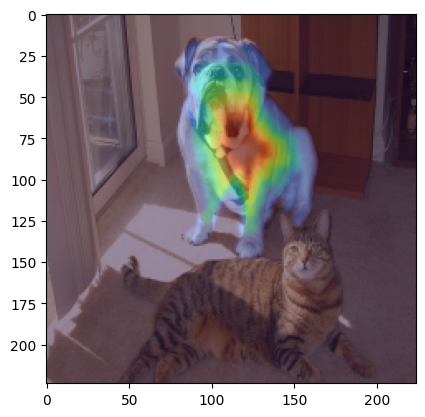

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [96]:
#| hide
visualize_saliency_overlay(np.array(image), np_mask)

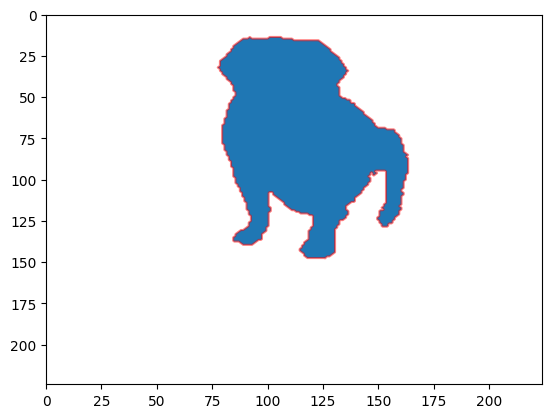

In [97]:
#| hide
plot_polygon(polygon, 224, 224)

In [98]:
#| export
from shapely import simplify

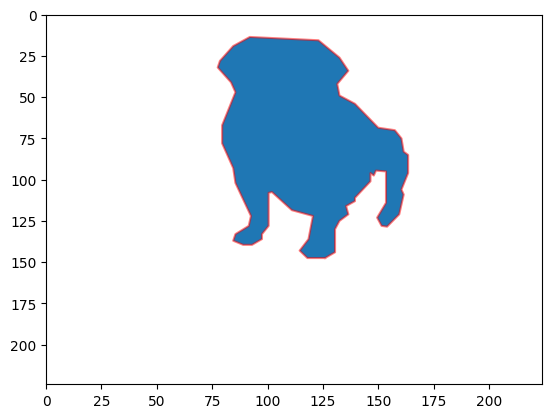

In [99]:
#| hide
decimated_poly = simplify(polygon, 1, preserve_topology=False)
plot_polygon(decimated_poly, 224, 224)

In [100]:
#| hide
num_of_scaling_op = 7
saliency_value = 1/num_of_scaling_op

scale_val = 1;
np_mask = np.zeros_like(mask, dtype=float)

decimation_tolerance = 1
decimated_poly = simplify(polygon, decimation_tolerance, preserve_topology=False)

height, width = np_mask.shape
for _ in range(num_of_scaling_op):
    decimated_poly = simplify(decimated_poly, decimation_tolerance, preserve_topology=False)
    scaled_polygon = scale(decimated_poly, xfact=scale_val, yfact=scale_val)
    for y in range(height):
        for x in range(width):
            if scaled_polygon.contains(Point(y, x)):
                np_mask[y, x] += saliency_value
    scale_val *= 0.8
    decimation_tolerance *= 1.7

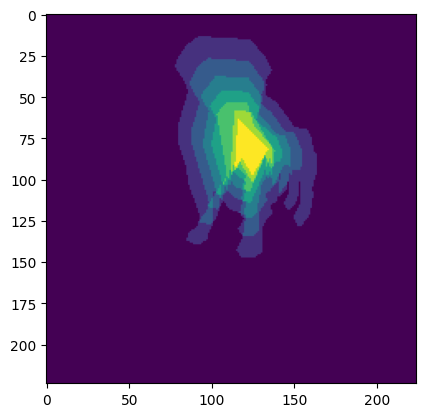

In [101]:
plt.imshow(np_mask)

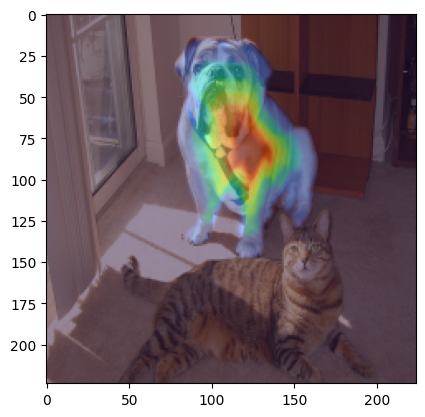

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [102]:
#| hide
np_mask = convolve2d(np_mask, kernel, mode='full')

visualize_saliency_overlay(np.array(image), np_mask)

## Patching it all together

In [2]:
#| hide
def generate_segmentation_mask(image, coords=None):
#     sam_model_full_path = os.path.join(current_dir, "abid/vendors/sam_vit_b_01ec64.pth")
    sam_model_full_path = "/project/validating_attribution_techniques/abid/vendors/sam_vit_b_01ec64.pth"
    sam = sam_model_registry["vit_b"](checkpoint=sam_model_full_path)
    predictor = SamPredictor(sam)
    predictor.set_image(image)
    input_label = np.array([1])

    masks, scores, logits = predictor.predict(point_coords=coords, point_labels=input_label, multimask_output=True)
    return masks, scores, logits

In [108]:
#| hide
masks, scores, logits = generate_segmentation_mask(np.array(image), np.array([[100, 50]]))

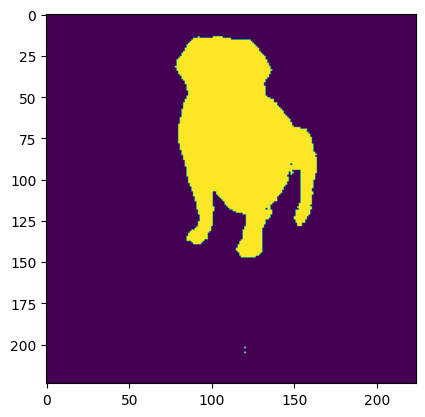

In [111]:
#| hide
plt.imshow(masks[0])

In [112]:
#| export
def pixels_to_polygon(pixels):
    contours = measure.find_contours(pixels, 0.5, fully_connected='high')
    longest_coutour = max(contours, key=len)
    polygon = Polygon(longest_coutour)

    return polygon

In [113]:
#| hide
polygon = pixels_to_polygon(masks[0])

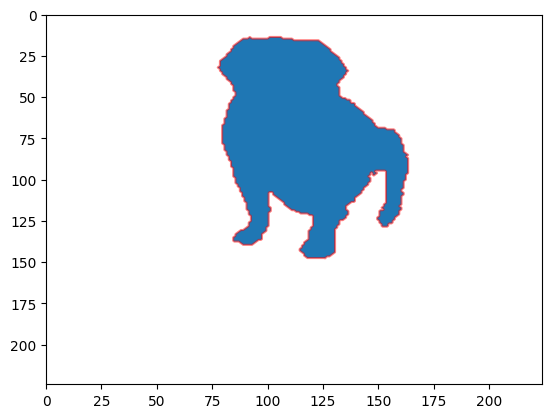

In [114]:
#| hide
plot_polygon(polygon, 224, 224)

In [127]:
#| export

# This thing is slow as hell, screw python and whoever decided to start using python for deep learning.
# Needs to be optimized
def polygon_to_pixels(polygon, height, width):
    """
    Converts a 2D shapely polygon into a numpy array mask {0, 1}
    
    input :
      - polygon : shapely Polygon
      - height : int (height of the desired raster)
      - width : int (width of the desired raster)
    return :
      - array : ndarray (resterized mask)
    """
    # height, width = arr.shape
    array = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            if polygon.contains(Point(y, x)):
                array[y, x] = 1
    return array

In [123]:
#| hide
gen_mask = polygon_to_pixels(polygon, 224, 224)

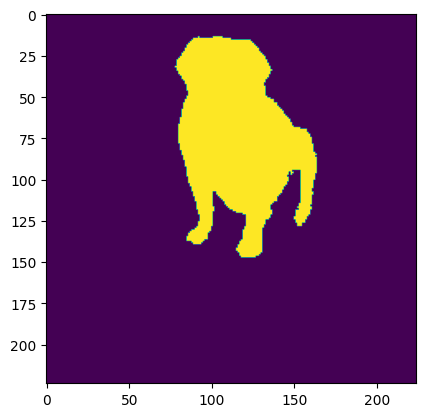

In [126]:
#| hide
plt.imshow(gen_mask)

In [144]:
#| export
def generate_saliency_from_polygon(polygon, height, width):
    """
    Generates a rasterized and smoothed saliency map using a polygonal shape,
    through iterative decimation and scaling down.
    
    input :
      - polygon : shapely Polygon
      - height : int (height of the desired raster)
      - width : int (width of the desired raster)
    return :
      - np_mask : ndarray (resterized and smoothed saliency map)
    """
    kernel = np.array([
    [ 45,  78, 128,  78, 45],
    [ 78, 128, 170, 128, 78],
    [128, 170, 255, 170, 128],
    [ 78, 128, 170, 128, 78],
    [ 45,  78, 128,  78, 45]])

    kernel = kernel/kernel.sum()

    num_of_scaling_op = 7
    saliency_value = 1/num_of_scaling_op

    scale_val = 1;
    np_mask = np.zeros((height, width), dtype=float)

    decimation_tolerance = 1
    decimated_poly = simplify(polygon, decimation_tolerance, preserve_topology=False)

    for _ in range(num_of_scaling_op):
        decimated_poly = simplify(decimated_poly, decimation_tolerance, preserve_topology=False)
        scaled_polygon = scale(decimated_poly, xfact=scale_val, yfact=scale_val)
        for y in range(height):
            for x in range(width):
                if scaled_polygon.contains(Point(y, x)):
                    np_mask[y, x] += saliency_value
        scale_val *= 0.86
        decimation_tolerance *= 1.7
    np_mask = convolve2d(np_mask, kernel, mode='full')

    return np_mask

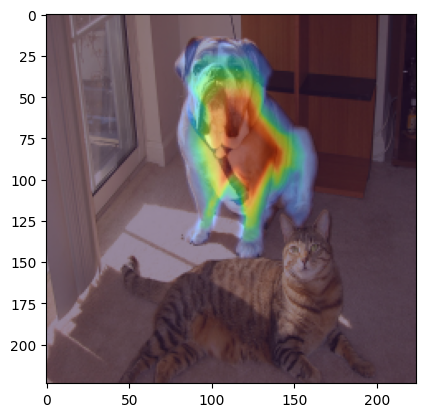

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [145]:
#| hide
saliency = generate_saliency_from_polygon(polygon, 224, 224)
visualize_saliency_overlay(np.array(image), saliency)

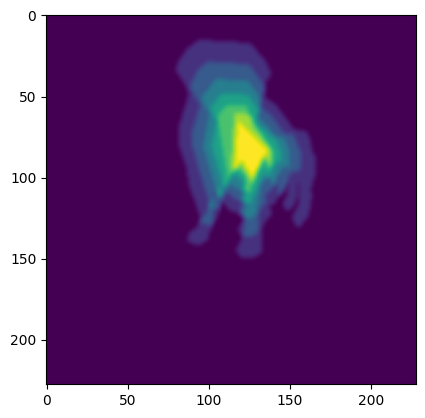

In [139]:
#| hide
plt.imshow(saliency)

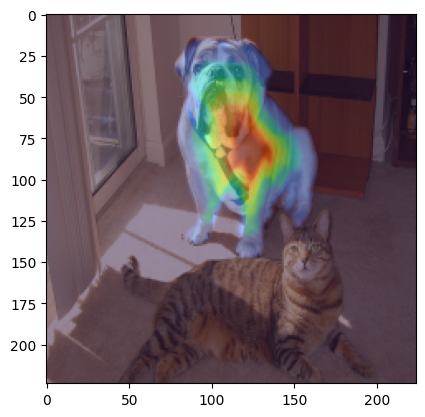

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [140]:
#| hide
visualize_saliency_overlay(np.array(image), saliency)

### YOLO-based segmentation

In [8]:
#| export
yolo_model = YOLO('yolov8m-seg.pt')

In [9]:
#| export
def yolo_generate_segmentation_mask(image, yolo_model=yolo_model):
    """
    Generates segmentation masks using YOLOv8, and returns the largest segmented area
    
    input :
      - image : ndarray
      - segment_model : func (optional)
        (YOLOv8 model given without api modification)
    return :
      - mask : ndarray (if YOLO model found a mask)
      - None (if a mask cannot be created) 
    """
    results = yolo_model(img_input)
    if results[0].masks != None:
        return np.array(Image.fromarray(results[0].masks.cpu().data[0].numpy()).resize((224, 224)))
    else:
        return results[0].masks

In [ ]:
def yolo_generate_groundsaliency_from_mask(image, yolo_model):
    """
    The function accept image and the YOLOv8 segmentation model and returns a ground saliency
    generated through segmentation data.
    The output must be checked for None values.
    
    input :
      - image : ndarray
      - segment_model : func (optional)
        (YOLOv8 model given without api modification)
    return :
      - saliency : ndarray (if YOLO model found a mask)
      - None (if a mask cannot be created)
    """
    mask = generate_yolo_segmentation_mask(segment_model, image)
    if type(mask) != type(None):
        poly_mask = pixels_to_polygon(mask)
        saliency = generate_saliency_from_polygon(poly_mask, image.shape[0], image.shape[1])
        return saliency
    else:
        return None

In [6]:
#| hide
from nbdev.export import nb_export
nb_export('ground_truth_saliency_generation.ipynb', '../../commons/api')

In [ ]:
# x = np.linspace(0, mask.shape[0]-1, mask.shape[0])
# y = np.linspace(0, mask.shape[1]-1, mask.shape[1])

# grid = np.meshgrid(y, x)
# np.dstack((grid[1], grid[0])).reshape(-1, 2).astype("int32")
# height = sample_images[4].shape[0]
# width = sample_images[4].shape[1]

# x = np.linspace(0, width-1, width)
# y = np.linspace(0, height-1, height)

# grid = np.meshgrid(y, x)
# array = np.zeros((height, width))
# indices = np.dstack((grid[1], grid[0])).reshape(-1, 2).astype("int32")
# for x, y in indices:
#     if poly_mask.contains(Point(y, x)):
#         array[y, x] = 1